In [1]:
import sys
sys.path.append('/Users/leah/Columbia/courses/19summer/SocialBehavior/SocialBehaviorptc')

In [2]:
from socialbehavior.models.hmm import HMM
from socialbehavior.observations.ar_sigmoid_normal_observation import ARSigmoidNormalObservation
from socialbehavior.distributions.sigmoidnormal import SigmoidNormal
from socialbehavior.transformations.linear import LinearTransformation
from socialbehavior.utils import find_permutation, random_rotation, k_step_prediction

import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm
import sys
import time

In [3]:
import joblib

datasets_processed = joblib.load('/Users/leah/Columbia/courses/19summer/SocialBehavior/tracedata/all_data_3_1')  # a list of length 30, each is a social_dataset

rendered_data = []
for dataset in datasets_processed:
    session_data = dataset.render_trajectories([3,8])  # list of length 2, each item is an array (T, 2). T = 36000
    rendered_data.append(np.concatenate((session_data),axis = 1)) # each item is an array (T, 4)
trajectories = np.concatenate(rendered_data,axis = 0)  # (T*30, 4)

traj29 = rendered_data[29]

# try lr = 0.001

In [4]:
arena_xmax = 320
arena_ymax = 370

In [5]:
K = 5
D = 4
T = 36000

bounds = np.array([[-100, arena_xmax + 130], [-100, arena_ymax + 130], [-100, arena_xmax + 130],
                   [-100, arena_ymax + 130]])

#bounds = np.array([[-300, 300], [-300, 300], [-300, 300], [-300, 300]])

## Note: I relax boundaries to be (much) wider than the original arena.

In [6]:
tran = LinearTransformation(K=K, d_in=D, d_out=D)
observation = ARSigmoidNormalObservation(K=K, D=D, M=0, transformation=tran, bounds=bounds)

model = HMM(K=K, D=D, M=0, observation=observation)

data = torch.tensor(traj29, dtype=torch.float64)

In [7]:
model.log_likelihood(data)

tensor(-3.6344e+08, dtype=torch.float64, grad_fn=<HMMNormalizerCythonBackward>)

In [9]:
num_iters = 1000
pbar = tqdm(total=num_iters, file=sys.stdout)

optimizer = torch.optim.Adam(model.params, lr=0.001)

losses = []
for i in np.arange(num_iters):

    optimizer.zero_grad()

    loss = model.loss(data)
    loss.backward(retain_graph=True)
    optimizer.step()
    losses.append(loss.detach().numpy())
    
    if i % 10 == 0:
        pbar.set_description('iter {} loss {:.2f}'.format(i, loss))
        pbar.update(10)
        
pbar.close()

In [10]:
# TODO: try not training sigmas, and adjust initialization point

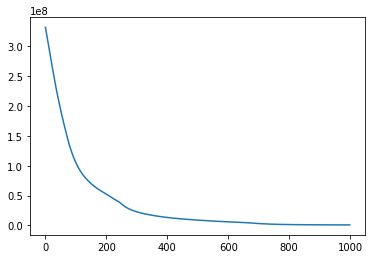

In [11]:
plt.plot(losses)

In [12]:
sample_z, sample_x = model.sample(100)

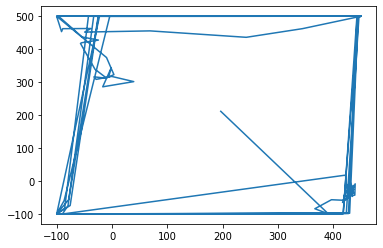

In [13]:
plt.plot(sample_x[:, 0], sample_x[:,1], label='virgin')
plt.plot(sample_x[:, 2], sample_x[:,3], label='mother')
plt.legend()

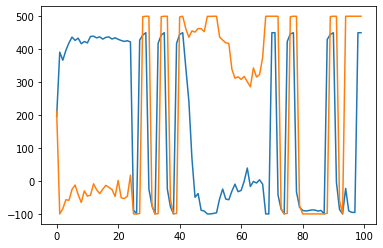

In [19]:
plt.plot(sample_x[:,0])
plt.plot(sample_x[:,1])

In [16]:
torch.exp(model.observation.log_sigmas)

tensor([[1.9230, 1.9981, 1.9337, 1.9981],
        [1.0648, 1.2375, 1.1208, 1.1300],
        [1.6124, 1.4004, 1.3058, 1.3471],
        [1.1717, 1.1839, 1.3230, 1.1854],
        [1.1444, 1.1569, 1.1175, 1.1837]], dtype=torch.float64,
       grad_fn=<ExpBackward>)

Text(0.5, 0, 'time')

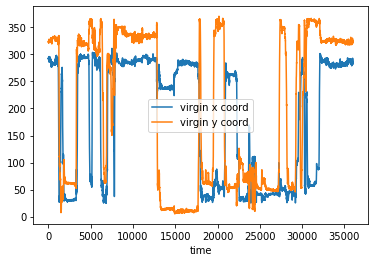

In [57]:
plt.plot(traj29[:,0], label='virgin x coord')
plt.plot(traj29[:,1], label='virgin y coord')
plt.legend()
plt.xlabel('time')

In [21]:
sample_z, sample_x = model.sample(10000)

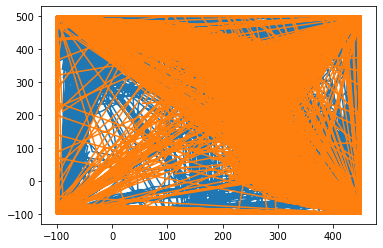

In [26]:
plt.plot(sample_x[:,0], sample_x[:, 1])
plt.plot(sample_x[:,2], sample_x[:,3])

train for another 1000 iters

In [27]:
for i in np.arange(num_iters):

    optimizer.zero_grad()

    loss = model.loss(data)
    loss.backward(retain_graph=True)
    optimizer.step()
    losses.append(loss.detach().numpy())
    
    if i % 10 == 0:
        pbar.set_description('iter {} loss {:.2f}'.format(i, loss))
        pbar.update(10)

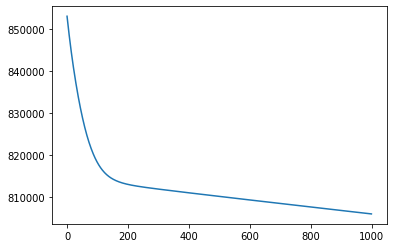

In [29]:
plt.plot(losses[1000:])

In [30]:
sample_z, sample_x = model.sample(100)

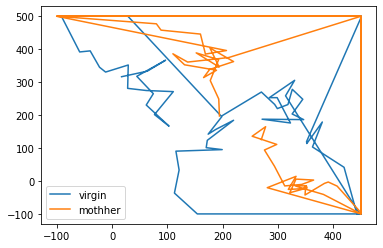

In [34]:
plt.plot(sample_x[:,0], sample_x[:,1], label='virgin')
plt.plot(sample_x[:,2], sample_x[:, 3], label='mothher')
plt.legend()

# check prediction

First infer the most likely hidden states, and then condition on this sequence to sample observations.

In [35]:
z = model.most_likely_states(data)

In [36]:
x_predict_arr = k_step_prediction(model, z, data)

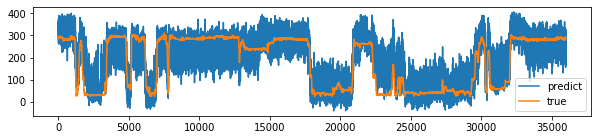

In [40]:
plt.figure(figsize=(10,2))
plt.plot(x_predict_arr[:,0], label='predict')
plt.plot(data[:,0].numpy(), label='true')
plt.legend()
plt.show()

train for another 5000 iters

In [41]:
for i in np.arange(5000):

    optimizer.zero_grad()

    loss = model.loss(data)
    loss.backward(retain_graph=True)
    optimizer.step()
    losses.append(loss.detach().numpy())
    
    if i % 10 == 0:
        pbar.set_description('iter {} loss {:.2f}'.format(i, loss))
        pbar.update(10)

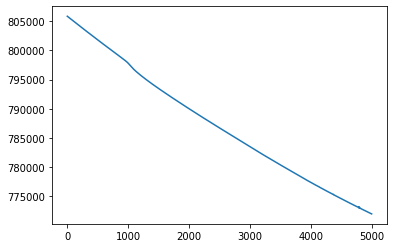

In [42]:
plt.plot(losses[2000:])

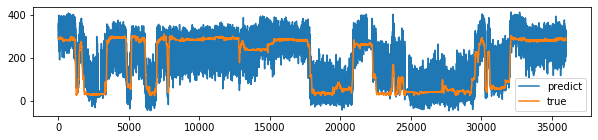

In [43]:
z = model.most_likely_states(data)
x_predict_arr = k_step_prediction(model, z, data)

plt.figure(figsize=(10,2))
plt.plot(x_predict_arr[:,0], label='predict')
plt.plot(data[:,0].numpy(), label='true')
plt.legend()
plt.show()

In [50]:
sample_z, sample_x = model.sample(1000)

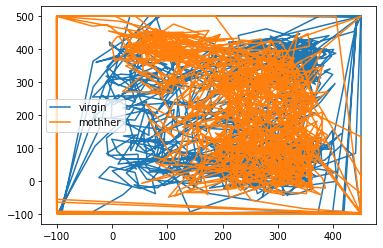

In [51]:
plt.plot(sample_x[:,0], sample_x[:,1], label='virgin')
plt.plot(sample_x[:,2], sample_x[:, 3], label='mothher')
plt.legend()

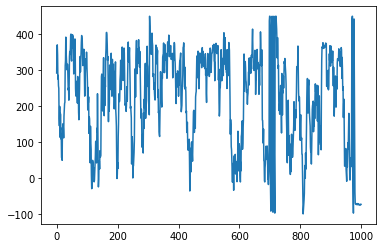

In [56]:
plt.plot(sample_x[:,0])